# Annex
## Modulation transfer functions and linear systems
### Juan Camilo Buitrago-Casas

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as fits
import glob as gl
from matplotlib.colors import LogNorm
import seaborn as sns
sns.plotting_context('talk')
sns.set_style("dark")

In [2]:
# reading darks and images in-focus
darks =  gl.glob("MTF/dark*")
imgs =  gl.glob("MTF/in-focus-1-*")
# how many darks and images
nd = np.size(darks)
ni = np.size(imgs)

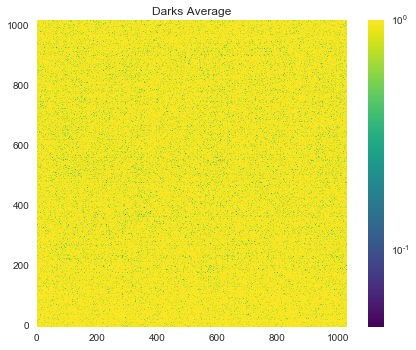

In [3]:
shapedark = fits.getdata(darks[0]).shape
darks_arr = np.zeros((nd,shapedark[0],shapedark[1]))

for i in range (0,nd):
    darks_arr[i,:,:] = fits.getdata(darks[i])

darkmean=np.mean(darks_arr,axis=0)
norm = LogNorm(vmax=1)
plt.imshow(darkmean,norm=norm,cmap='viridis',origin="lower")
plt.colorbar()
plt.title("Darks Average")

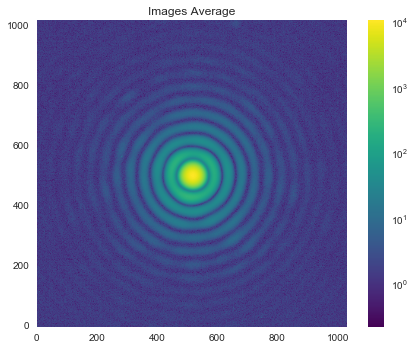

In [4]:
shapeim = fits.getdata(imgs[0]).shape
imgs_arr = np.zeros((ni,shapeim[0],shapeim[1]))

for i in range (0,ni):
    imgs_arr[i,:,:] = fits.getdata(imgs[i])

imgmean=np.mean(imgs_arr,axis=0)
norm = LogNorm()
plt.imshow(imgmean, norm=norm,cmap='viridis',origin="lower")
plt.colorbar()
plt.title("Images Average")

## weighted images

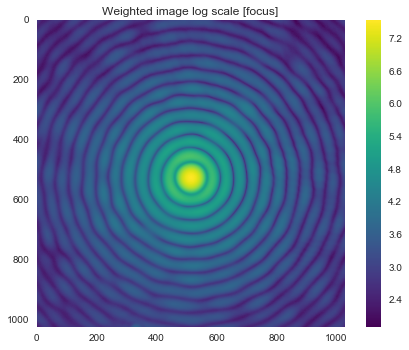

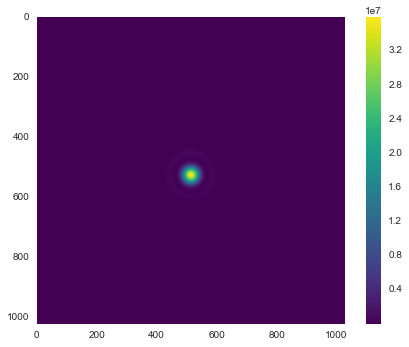

In [5]:
sns.set_style("dark")
# reading darks and images in-focus different exp times
darks = gl.glob("MTF-seq-in-focus/log-t-seq-2-00*")
imgs = gl.glob("MTF-seq-in-focus/log-t-seq-1-00*")

#DARKS

dark0=np.zeros(fits.getdata(darks[0]).shape)
dark1=np.zeros(fits.getdata(darks[0]).shape)
dark2=np.zeros(fits.getdata(darks[0]).shape)
dark3=np.zeros(fits.getdata(darks[0]).shape)

for dark in darks:
    hdr=fits.getheader(dark)
    exptime = hdr.get('EXPTIME')
    if (exptime == 1e0):
        dark0 = dark0 + fits.getdata(dark)
        #print(exptime)
    if (exptime == 1e-1):
        dark1 = dark1 + fits.getdata(dark)
        #print(exptime)        
    if (exptime == 1e-2):
        dark2 = dark2 + fits.getdata(dark)
        #print(exptime)
    if (exptime == 1e-3):
        dark3 = dark3 + fits.getdata(dark)
        #print(exptime)

#IMAGES

img0=np.zeros(fits.getdata(imgs[0]).shape)
img1=np.zeros(fits.getdata(imgs[0]).shape)
img2=np.zeros(fits.getdata(imgs[0]).shape)
img3=np.zeros(fits.getdata(imgs[0]).shape)

for img in imgs:
    hdr=fits.getheader(img)
    exptime = hdr.get('EXPTIME')
    if (exptime == 1e0):
        img0 = img0 + fits.getdata(img)
    if (exptime == 1e-1):
        img1 = img1 + fits.getdata(img)
    if (exptime == 1e-2):
        img2 = img2 + fits.getdata(img)
    if (exptime == 1e-3):
        img3 = img3 + fits.getdata(img)        

img0 = np.abs(img0 - dark0)
img2 = np.abs(img2 - dark2)
img1 = np.abs(img1 - dark1)
img3 = np.abs(img3 - dark3)

zeros = np.zeros(fits.getdata(imgs[0]).shape)
remv3 = 1e-3*np.where(img3 > 3.6e4, zeros, 1.0)
remv2 = 1e-2*np.where(img2 > 3.6e4, zeros ,1.0)
remv1 = 1e-1*np.where(img1 > 3.6e4, zeros, 1.0)
remv0 = 1e+0*np.where(img0 > 3.6e4, zeros, 1.0)

nimg3 = 1e3*img3
nimg2 = 1e2*img2
nimg1 = 1e1*img1
nimg0 = 1e0*img0

remvt = (remv3 + remv2 + remv1 + remv0)
final = (nimg3*remv3 + nimg2*remv2 + nimg1*remv1 + nimg0*remv0 )/remvt

plt.figure()
plt.imshow(np.log10(final+1),cmap='viridis')
plt.title('Weighted image log scale [focus]')
plt.colorbar()
plt.show()
plt.imshow(final,cmap='viridis')  
plt.colorbar()
plt.show()

## Calculate the cutoff frequency

(0, 1024)

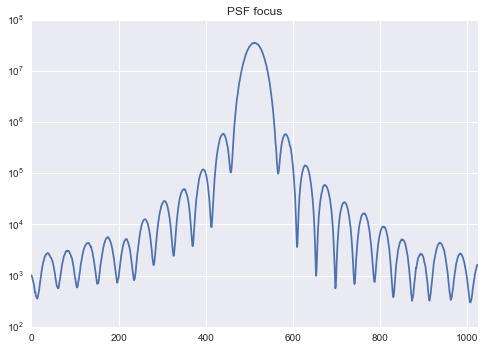

In [9]:
fm = np.where(final == final.max())
sns.set_style("darkgrid")
data = final[fm[0][0],:]
plt.semilogy(data)
plt.title('PSF focus')
plt.xlim(0,1024)

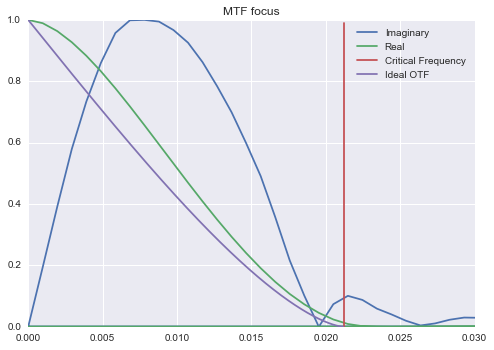

In [8]:
f = 180e-3 #180 mm focal length
D = 14e-3
NA = 1/(2*f/D)
nu = 2*NA/635e-9
#change to cycles per pixel
nu_pix = nu*7.7e-6/44.5 #multiply by pixel size and divide by magnification

norm_real = max(np.abs((np.real(np.fft.fft(data)))))
norm_im = max(np.abs((np.imag(np.fft.fft(data)))))
#Plot the real and imaginary bits of the fourier transform, normalized to the cutoff frequency
freqs = np.fft.fftfreq(data.size)
plt.plot(freqs,np.abs(np.imag(np.fft.fft(data)))/norm_im, label = 'Imaginary')
plt.plot(freqs,np.abs(np.real(np.fft.fft(data)))/norm_real, label = 'Real')
plt.xlim(0,.03)
plt.plot((np.zeros(100)+nu_pix),np.arange(0,1,.01), label = 'Critical Frequency')

#get ideal otf from euqation on page 3 of the lab

nu_p = np.arange(0,1,.001)
ideal_otf = 2/np.pi*(np.arccos(np.abs(nu_p))-np.abs(nu_p)*np.sqrt(1-nu_p**2))

plt.plot(nu_p*nu_pix,ideal_otf, label = 'Ideal OTF')
plt.title('MTF focus')
plt.legend()
plt.show()

# Defocus

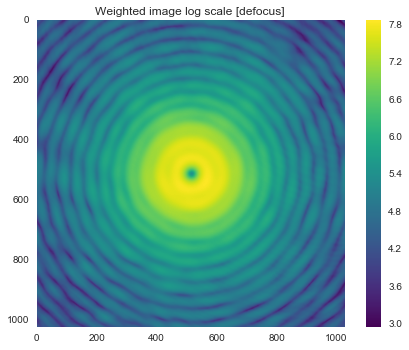

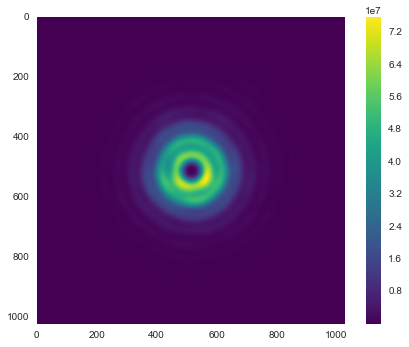

In [10]:
sns.set_style("dark")
# reading darks and images in-focus different exp times
imgs = gl.glob("MTF-seq-1-wave-defocus/log-t-seq-defocus-1-00*")
darks = gl.glob("MTF-seq-1-wave-defocus/log-t-seq-defocus-2-00*")

#DARKS

dark0=np.zeros(fits.getdata(darks[0]).shape)
dark1=np.zeros(fits.getdata(darks[0]).shape)
dark2=np.zeros(fits.getdata(darks[0]).shape)
dark3=np.zeros(fits.getdata(darks[0]).shape)

for dark in darks:
    hdr=fits.getheader(dark)
    exptime = hdr.get('EXPTIME')
    if (exptime == 1e0):
        dark0 = dark0 + fits.getdata(dark)
        #print(exptime)
    if (exptime == 1e-1):
        dark1 = dark1 + fits.getdata(dark)
        #print(exptime)        
    if (exptime == 1e-2):
        dark2 = dark2 + fits.getdata(dark)
        #print(exptime)
    if (exptime == 1e-3):
        dark3 = dark3 + fits.getdata(dark)
        #print(exptime)

#IMAGES

img0=np.zeros(fits.getdata(imgs[0]).shape)
img1=np.zeros(fits.getdata(imgs[0]).shape)
img2=np.zeros(fits.getdata(imgs[0]).shape)
img3=np.zeros(fits.getdata(imgs[0]).shape)

for img in imgs:
    hdr=fits.getheader(img)
    exptime = hdr.get('EXPTIME')
    if (exptime == 1e0):
        img0 = img0 + fits.getdata(img)
    if (exptime == 1e-1):
        img1 = img1 + fits.getdata(img)
    if (exptime == 1e-2):
        img2 = img2 + fits.getdata(img)
    if (exptime == 1e-3):
        img3 = img3 + fits.getdata(img)        

img0 = np.abs(img0 - dark0)
img2 = np.abs(img2 - dark2)
img1 = np.abs(img1 - dark1)
img3 = np.abs(img3 - dark3)

zeros = np.zeros(fits.getdata(imgs[0]).shape)
remv3 = 1e-3*np.where(img3 > 7.8e4, zeros, 1.0)
remv2 = 1e-2*np.where(img2 > 7.8e4, zeros ,1.0)
remv1 = 1e-1*np.where(img1 > 7.8e4, zeros, 1.0)
remv0 = 1e+0*np.where(img0 > 7.8e4, zeros, 1.0)

nimg3 = 1e3*img3
nimg2 = 1e2*img2
nimg1 = 1e1*img1
nimg0 = 1e0*img0

remvt = (remv3 + remv2 + remv1 + remv0)
final = (nimg3*remv3 + nimg2*remv2 + nimg1*remv1 + nimg0*remv0 )/remvt

plt.figure()
plt.imshow(np.log10(final+1),cmap='viridis')
plt.title('Weighted image log scale [defocus]')
plt.colorbar()
plt.show()
plt.imshow(final,cmap='viridis')  
plt.colorbar()
plt.show()

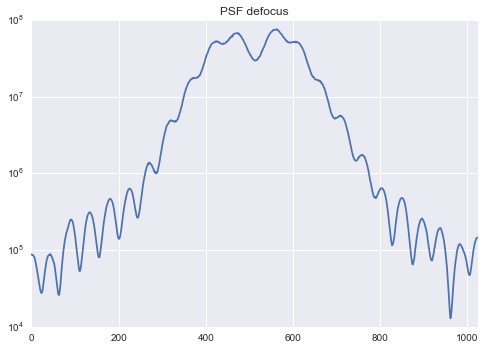

In [14]:
fm = np.where(final == final.max())
data = final[fm[0][0],:]
plt.semilogy(data)
plt.title('PSF defocus')
plt.xlim(0,1024)
sns.set_style("darkgrid")

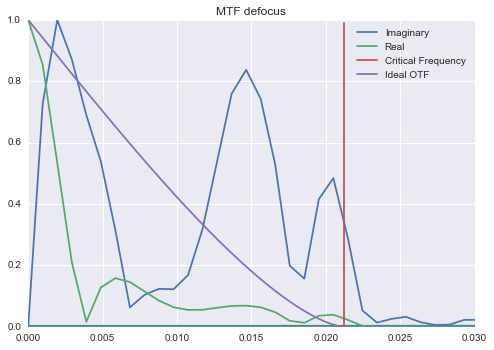

In [15]:
f = 180e-3 #180 mm focal length
D = 14e-3
NA = 1/(2*f/D)
nu = 2*NA/635e-9
#change to cycles per pixel
nu_pix = nu*7.7e-6/44.5 #multiply by pixel size and divide by magnification

norm_real = max(np.abs((np.real(np.fft.fft(data)))))
norm_im = max(np.abs((np.imag(np.fft.fft(data)))))
#Plot the real and imaginary bits of the fourier transform, normalized to the cutoff frequency
freqs = np.fft.fftfreq(data.size)
plt.plot(freqs,np.abs(np.imag(np.fft.fft(data)))/norm_im, label = 'Imaginary')
plt.plot(freqs,np.abs(np.real(np.fft.fft(data)))/norm_real, label = 'Real')
plt.xlim(0,.03)
plt.plot((np.zeros(100)+nu_pix),np.arange(0,1,.01), label = 'Critical Frequency')

#get ideal otf from euqation on page 3 of the lab

nu_p = np.arange(0,1,.001)
ideal_otf = 2/np.pi*(np.arccos(np.abs(nu_p))-np.abs(nu_p)*np.sqrt(1-nu_p**2))

plt.plot(nu_p*nu_pix,ideal_otf, label = 'Ideal OTF')
plt.legend()
plt.title('MTF defocus')
plt.show()